In [4]:
import numpy as np
import torch
import argparse
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

from utils.mapper_DFS import * 
from utils.construct_graph_dataset import *
from utils.visualize_voxel_to_graph import *


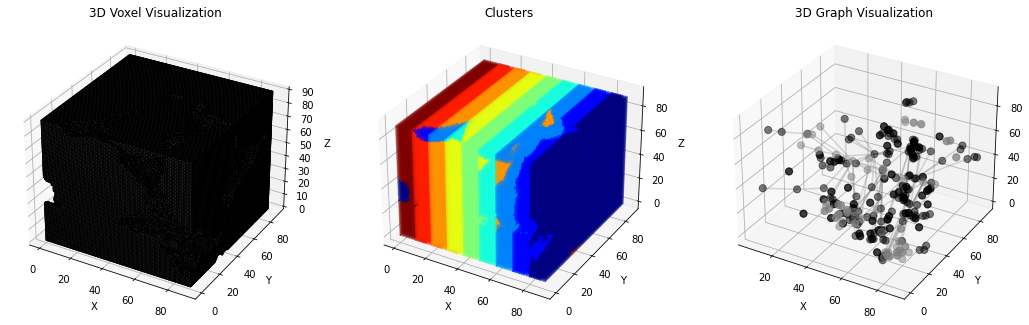

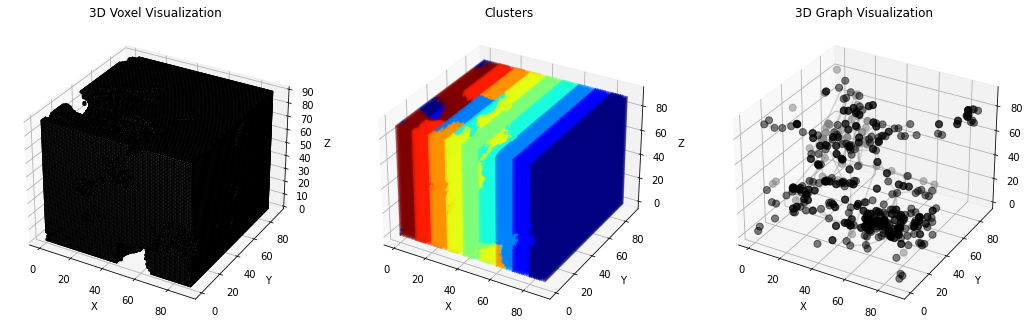

List of problematic data numbers: []
./examples/graph_data/


In [6]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--Rock', type=str, default='B1', help='rock image type')
    parser.add_argument('--start_no', type=int, default=1, help='Starting index for loading data') #1
    parser.add_argument('--end_no', type=int, default=2, help='Ending index for loading data') #3
    parser.add_argument('--subcube', type=int, default=90, help='subcube size') #75
    parser.add_argument('--stiff_data_dir', type=str, 
                       default='./examples/material_property_data')
    parser.add_argument('--save_data_dir', type=str, 
                       default='./examples/graph_data')    
    parser.add_argument('--cover_interval', type=int, default=10, help='Mapper_parameter_cover_interval (related to resolution)')
    parser.add_argument('--overlap', type=float, default=0.7, help='Mapper_parameter_overlap')
    args = parser.parse_args([])
    
    subcube_size = args.subcube
    img_data_dir =f'./examples/voxel_img_data'    
    stiff_data_dir = f'{args.stiff_data_dir}'    
    stiff_data = f'/stiffness_{subcube_size}.dat'
    stiff_file = stiff_data_dir + stiff_data
    avg_scheme = 'Voigt'
    
    # define mapper variables
    interval = args.cover_interval
    overlap = args.overlap
    overlap_pixel = math.ceil(interval*overlap)
    x_range_list = [(i, min(i+interval + overlap_pixel, args.subcube)) for i in range(0, args.subcube, interval)]
    total_voxels = args.subcube**3
    threshold = 0.001 * total_voxels  # Ignore 0.1% of total voxels
    

    results = []
    problematic_data_numbers = []
    for i in range(args.start_no, args.end_no+1):
        try:
            # 1) Load data
            drp_id = i
            file = f'Rock_{subcube_size}_{drp_id}.raw'
            data = load_data_from_file(os.path.join(img_data_dir, file), subcube_size=subcube_size)
            voxel_data = data

            # 2) Mapper algorithm with DFS Clustering (3d point cloud -> projection in x-axis -> covering -> clustering)
            # DFS clustering for solid
            solid_clusters_list, solid_cids_list = find_clusters_list(data, x_range_list, threshold)
            solid_overlaps = find_overlaps_from_cids(x_range_list, solid_clusters_list, solid_cids_list, overlap_thickness=overlap_pixel) # edges

            # DFS clustering for pore
            pore_clusters_list, pore_cids_list = find_clusters_list(np.where(data==1, 0, 1), x_range_list, threshold)
            pore_overlaps = find_overlaps_from_cids(x_range_list, pore_clusters_list, pore_cids_list, overlap_thickness=overlap_pixel) # edges  

            # 3) Construct graph dataset features
            # 3.1) Node features
            # Extract all node features
            nodes_solid = extract_all_node_features(solid_clusters_list, is_solid=True)
            nodes_pore = extract_all_node_features(pore_clusters_list, is_solid=False)
            # Concatenate solid and pore nodes
            nodes = np.concatenate([nodes_solid, nodes_pore], axis=0)
            # create a networkx graph
            G = nx.Graph()
            G.add_nodes_from(range(nodes.shape[0]))

            # 3.2) Edge features 
            solid_offset = 0
            pore_offset = len(nodes_solid)
            solid_edges = extract_edges_from_overlaps(solid_overlaps, solid_offset)
            pore_edges = extract_edges_from_overlaps(pore_overlaps, pore_offset)

            G.add_edges_from(solid_edges)
            G.add_edges_from(pore_edges)

            # 3.3) Add graph topological features on node features
            nodes = compute_graph_topological_features(G, nodes)

            # 4) Load labels
            stiffness= load_stiffness_and_porosity(stiff_file, drp_id)
            stiffness = 0.5*(stiffness + stiffness.T)
            C = am.ElasticConstants(Cij=stiffness)
            bulk = C.bulk(avg_scheme)
            shear = C.shear(avg_scheme)

            # 5) Save graph dataset 
            # create a PyTorch Geometric Data object for the graph
            x = torch.tensor(nodes, dtype=torch.float)
            edge_index = torch.tensor(list(G.edges)).t().contiguous()
            data = Data(x=x, edge_index=edge_index, K_Voigt=bulk, mu_Voigt=shear)       
            results.append(data)

            # 6) Visualization part (optional)
            # Note: takes long time for visualization, uncomments these only for few samples 
            fig = plt.figure(figsize=(18, 6))

            # Subplot for voxels
            ax1 = fig.add_subplot(131, projection='3d')
            plot_voxels(voxel_data, ax1)

            # Subplot for clusters (you can choose to plot solid or pore clusters)
            ax2 = fig.add_subplot(132, projection='3d')
            solid_color_len = len(solid_clusters_list)
            pore_color_len = len(pore_clusters_list)
            solid_colors = plt.cm.jet(np.linspace(1, 0, solid_color_len))
            pore_colors = plt.cm.jet(np.linspace(0, 1, pore_color_len))

            # Plot solid clusters
            for i, solid_cluster in enumerate(solid_clusters_list):
                for cluster in solid_cluster:
                    plot_cluster(cluster, ax2, solid_colors[i])

            # Plot pore clusters
            for i, pore_cluster in enumerate(pore_clusters_list):
                for cluster in pore_cluster:
                    plot_cluster(cluster, ax2, pore_colors[i])

            # Subplot for graph
            ax3 = fig.add_subplot(133, projection='3d')
            plot_3d_graph(G, nodes, ax3)
            plt.show()

        except Exception as e:
            print(f"Error with data number {i}: {e}")
            problematic_data_numbers.append(i)   
            
    print("List of problematic data numbers:", problematic_data_numbers)

    # Filter out None values from results
    data_list = [x for x in results if x is not None]        
    

    # specify the dir to save the graph dataset
    graph_data_dir = args.save_data_dir +'/'
    print(graph_data_dir)
    
    # create the dir if it doesn't exist
    if not os.path.exists(graph_data_dir):
        os.makedirs(graph_data_dir)        
    
    # Save the dataset to a file using pickle
    with open(graph_data_dir + f'dataset_{args.start_no}_to_{args.end_no}.pkl', 'wb') as f:
        pickle.dump(data_list, f)    
                 